# NLP Project - Political line classification (Benoit Ané and Aymeric Floyrac)

This project consists in classifying the political line of a short text, typically a tweet. The dabase used is the one used for [this article](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0201879) (here is the [link](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2F6739SP)  to the dataset). It is exclusively made of tweets posted during the French 2017 presidential election and related to the election. 

The objective of this project is to classify the tweets into one of the five following classes: far-right, right, center, left, far-left. 

We use different types of models, ranging from the most simple ones (such as logistic regression) to more sophisticated one (fine-tuning CamemBERT).

# Set up on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
os.chdir('drive/My Drive/ENSAE/NLP')

In [3]:
!git clone https://github.com/aymericfloyrac/NLP-Political-line-classification.git

Cloning into 'NLP-Political-line-classification'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 95 (delta 52), reused 66 (delta 29), pack-reused 0
Unpacking objects: 100% (95/95), done.


In [0]:
os.chdir('NLP-Political-line-classification')

After cloning, one should put the enclosed .csv file in the folder ```data``` in order to be able to run this notebook.

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
def boldprint(s):
    print('\033[1m' + s + '\033[0m')

# 1. Data importation and description

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random 
import json

np.random.seed(0)
random.seed(0)

In [0]:
df = pd.read_csv('data/base_tweets_propre_sans_emoji.csv')

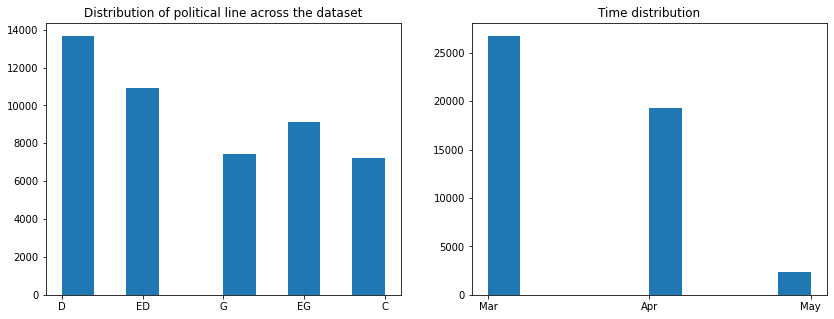

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.hist(df['couleur_politique'])
ax1.set_title('Distribution of political line across the dataset')
ax2.hist(df['mois'])
ax2.set_title('Time distribution')
plt.show()

Our dataset is approximately balanced, even if we have a slightly dominant class (Right). 

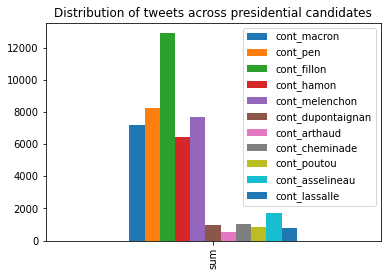

In [14]:
df.filter(regex='cont').aggregate(['sum']).plot.bar()
plt.title('Distribution of tweets across presidential candidates')
plt.show()

In [15]:
pd.crosstab(df.mois, df.couleur_politique)

couleur_politique,C,D,ED,EG,G
mois,,,,,
Apr,3604,5229,4426,3609,2402
Mar,2752,8382,5504,5269,4834
May,861,57,1005,243,200


# 2. Classification with random splitting

We take a first approach where we split the data without any time consideration (ie evenly across March, April and May).

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from utils.evaluation import evaluate,plot_confusion_matrix
from utils.utils import random_split_dataset,time_split_dataset,grid_search_classifier
import time
from scipy.sparse import vstack

In [0]:
Xtrain,ytrain,Xval,yval,Xtest,ytest,label_map = random_split_dataset(df,validation=True)

## 2.1 Classification without deep learning

We will evaluate a selection of models in order to have a benchmark for the deep learning methods we will use afterwards.

Prior to displaying the results, we performed a grid search on the hyperparameters to select the best ones, which we stored.

In [0]:
classifiers = {'Logistic regression':LogisticRegression(random_state=0),
               'SVM':SVC(random_state=0),
               'Random Forest': RandomForestClassifier(random_state=0),
               'Multi Layer Perceptron':MLPClassifier(random_state=0)}

The following cell is the grid search cell. **WARNING: DO NOT RUN, it takes hours to complete.**

In [0]:
#DO NOT RUN
parameters_logit = {'max_iter': [200],
                    'C': [1, 10, 100]
                    }
parameters_svm = {'C': [0.01,0.1,1,10,100], 
                  'gamma': [0.01,0.1,1,10,100]
                  }
parameters_rf = {'n_estimators': [300, 400, 600], 
                  'max_features': ['log2', 'sqrt'], 
                  'max_depth': [300, 500, 700], 
                  'min_samples_split': [500, 600, 700]
                }
parameter_nn = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                   'activation': ['tanh', 'relu'],
                   'solver': ['sgd', 'adam'],
                   'alpha': [0.01, 0.05],
                   'learning_rate': ['constant','adaptive'],
                   }
parameters = {'Logistic regression' : parameters_logit,  
              'SVM' : parameters_svm, 
              'Random Forest' : parameters_rf
              'Multi Layer Perceptron' : parameters_nn
              }

for name,clf in classifiers.items():
    clf = grid_search_classifier(clf,parameters[name])
    clf.fit(Xtrain,ytrain)
    ypred = clf.predict(Xval)
    boldprint('--------------'+name+'--------------')
    print(evaluate(yval,ypred))

We use the following code to evaluate the models on the validation set. We only show here, for clarity sake, the results with the best hyperparameters.

In [0]:
hp = json.load(open('data/hyperparameters_random.json'))

In [24]:
for name,clf in classifiers.items():
    clf = clf.set_params(**hp[name])
    clf.fit(Xtrain,ytrain)
    ypred = clf.predict(Xval)
    boldprint('--------------'+name+'--------------')
    print(evaluate(yval,ypred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


--------------Logistic regression--------------
   accuracy    recall  precision  f1-score
0  0.951008  0.949572   0.952101  0.950758
--------------SVM--------------
   accuracy    recall  precision  f1-score
0  0.950388  0.947677   0.953019  0.950157
--------------Random Forest--------------
   accuracy    recall  precision  f1-score
0  0.914935  0.900278   0.937438  0.914667
--------------Multi Layer Perceptron--------------
   accuracy   recall  precision  f1-score
0  0.947287  0.94622    0.94735  0.946737


Let's evaluate on the test set:

In [25]:
sorted_labels = [label_map[key] for key in sorted(label_map)]
sorted_labels

['C', 'D', 'ED', 'EG', 'G']

In [0]:
#use the complete training set
Xtrain_ = vstack((Xtrain, Xval)) 
ytrain_ = np.concatenate((ytrain, yval))

--------------Logistic regression--------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 11.2s
              precision    recall  f1-score   support

           C       0.96      0.95      0.96      1443
           D       0.95      0.97      0.96      2734
          ED       0.98      0.97      0.98      2187
          EG       0.99      0.98      0.98      1825
           G       0.97      0.96      0.96      1487

    accuracy                           0.97      9676
   macro avg       0.97      0.97      0.97      9676
weighted avg       0.97      0.97      0.97      9676



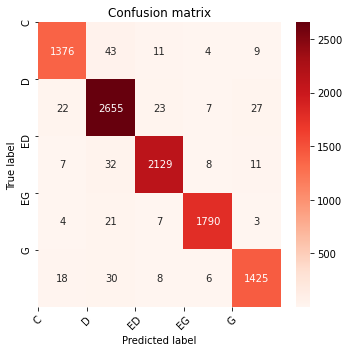

--------------SVM--------------
Training time: 236.1s
              precision    recall  f1-score   support

           C       0.97      0.95      0.96      1443
           D       0.94      0.98      0.96      2734
          ED       0.98      0.97      0.98      2187
          EG       0.99      0.98      0.98      1825
           G       0.97      0.96      0.97      1487

    accuracy                           0.97      9676
   macro avg       0.97      0.97      0.97      9676
weighted avg       0.97      0.97      0.97      9676



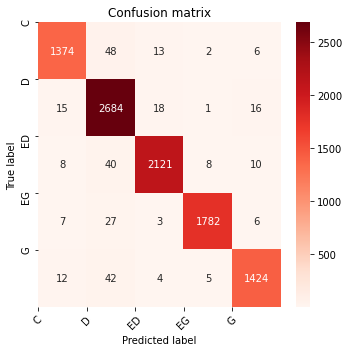

--------------Random Forest--------------
Training time: 35.1s
              precision    recall  f1-score   support

           C       0.99      0.86      0.92      1443
           D       0.87      0.98      0.92      2734
          ED       0.93      0.95      0.94      2187
          EG       0.98      0.96      0.97      1825
           G       0.98      0.88      0.93      1487

    accuracy                           0.94      9676
   macro avg       0.95      0.93      0.94      9676
weighted avg       0.94      0.94      0.94      9676



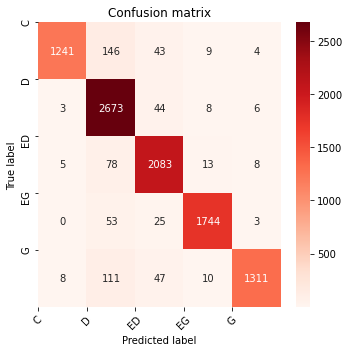

--------------Multi Layer Perceptron--------------
Training time: 169.8s
              precision    recall  f1-score   support

           C       0.96      0.95      0.96      1443
           D       0.95      0.97      0.96      2734
          ED       0.97      0.97      0.97      2187
          EG       0.99      0.98      0.98      1825
           G       0.96      0.95      0.96      1487

    accuracy                           0.97      9676
   macro avg       0.97      0.97      0.97      9676
weighted avg       0.97      0.97      0.97      9676



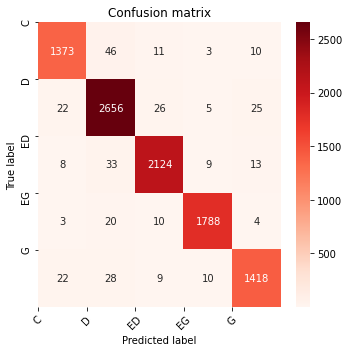

In [56]:
for name,clf in classifiers.items():
    boldprint('--------------'+name+'--------------')
    start = time.time()
    clf.fit(Xtrain_,ytrain_)
    end = time.time()
    print(f'Training time: {end-start:.1f}s')
    ypred = clf.predict(Xtest)
    print(classification_report(ytest,ypred,target_names = sorted_labels))
    plot_confusion_matrix(ytest,ypred,label_map=label_map)

The models we tested here perform very well, despite having a poor quality embedding. 

## 2.2 Classification using custom neural networks 

We now evaluate some classical neural networks, which often appear in the litterature as being well suited for NLP problems. We implement a LSTM, a convolutional network and finally a CamemBERT-based classifier. The two first models use the same embedding as the benchmark models.

In [0]:
!pip install transformers

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer, CamembertModel
import pandas as pd
from torch.utils.data import DataLoader
import pdb
from sklearn.metrics import accuracy_score
from utils.tweet_dataset import TweetDatasetBERT,build_tweet_dataset
from utils.evaluation import get_predictions
from classifiers import CamembertClassifier, RNN, CNN,train

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
dftrain,ytrain,dfval,yval,dftest,ytest,label_map = random_split_dataset(df,validation=True,deep=True)

In [0]:
train_set,tokenizer = build_tweet_dataset(dftrain)
val_set, _ = build_tweet_dataset(dfval,tokenizer)
test_set, _ = build_tweet_dataset(dftest,tokenizer)

train_loader = DataLoader(train_set,batch_size = 32,num_workers = 5,drop_last=True)
val_loader = DataLoader(val_set,batch_size = 32,num_workers = 5,drop_last=True)
test_loader = DataLoader(test_set,batch_size = 1,num_workers = 5,drop_last=False)

### 2.2.1 Custom LSTM

We implement a relatively shallow LSTM (2 layers), which uses no pretrained embedding. To boost its performance, we implement a learning rate scheduler, consisting in reducing the learning rate when the loss stagnates for too long, and to prevent it from overfitting too much we implement an early stopping procedure.

In [0]:
vocab_size = tokenizer.num_words+1
output_size = 5
embedding_dim = 128
hidden_dim = 100
n_layers = 2
model = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2, verbose=True)
activate_early_stopping = True

Iteration 400 of epoch 1 complete. Loss : 1.1886227130889893, Accuracy 0.71875 
Iteration 800 of epoch 1 complete. Loss : 1.0614304542541504, Accuracy 0.84375 
EVALUATION Validation set : mean loss 1.116883134407713 || mean accuracy 0.7769039869308472
Validation loss decreased (inf --> 337.298707).  Saving model ...
Iteration 400 of epoch 2 complete. Loss : 1.0963609218597412, Accuracy 0.78125 
Iteration 800 of epoch 2 complete. Loss : 0.9958122372627258, Accuracy 0.90625 
EVALUATION Validation set : mean loss 1.0631955828493005 || mean accuracy 0.834333598613739
Validation loss decreased (337.298707 --> 321.085066).  Saving model ...
Iteration 400 of epoch 3 complete. Loss : 1.0190788507461548, Accuracy 0.90625 
Iteration 800 of epoch 3 complete. Loss : 0.9853031635284424, Accuracy 0.9375 
EVALUATION Validation set : mean loss 1.0402740932853016 || mean accuracy 0.8573054671287537
Validation loss decreased (321.085066 --> 314.162776).  Saving model ...
Iteration 400 of epoch 4 complet

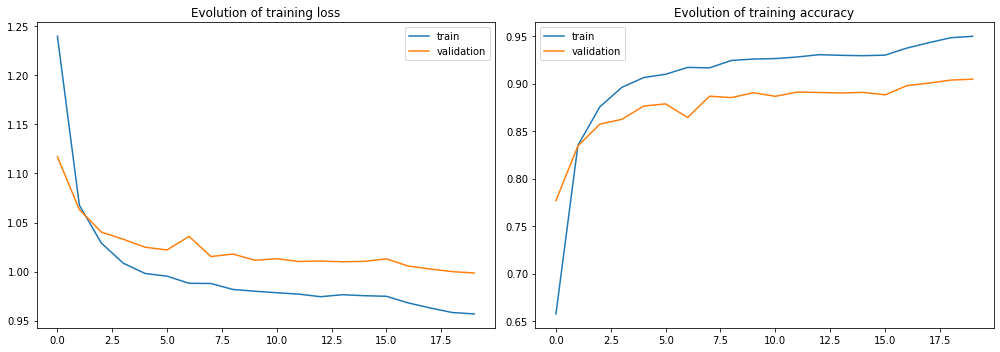

In [65]:
train(model, 'rnn',criterion, optimizer,activate_early_stopping,scheduler, train_loader, val_loader, n_epochs=20, print_every=400, gpu=True)

              precision    recall  f1-score   support

           C       0.88      0.87      0.87      1443
           D       0.90      0.92      0.91      2734
          ED       0.93      0.92      0.92      2187
          EG       0.95      0.93      0.94      1825
           G       0.87      0.88      0.87      1487

    accuracy                           0.91      9676
   macro avg       0.91      0.90      0.90      9676
weighted avg       0.91      0.91      0.91      9676



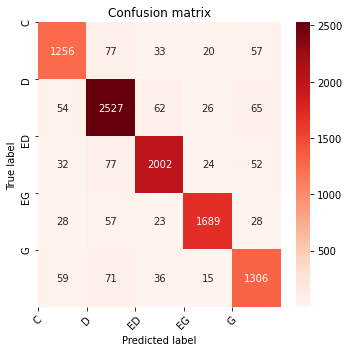

In [66]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,model_type='rnn')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

We observe that our LSTM obtains decent performances on the test set in a relatively short training time (despite the overfitting).

### 2.2.2 Custom Convolutional Network

Convolutional networks are quite commonly used in the literature of NLP problems, so we implement a custom convolutional network. To boost its performance and prevent it from overfitting too much, we use a learning rate scheduler and an early stopping procedure.

In [0]:
max_features = 8000
embed_dim = 128
num_filters = [64,64]
filter_sizes = [6,6]
model = CNN(max_features,embed_dim,num_filters,filter_sizes)
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2, verbose=True)
activate_early_stopping = True

Iteration 400 of epoch 1 complete. Loss : 0.7073087096214294, Accuracy 0.71875 
Iteration 800 of epoch 1 complete. Loss : 0.2924410104751587, Accuracy 0.9375 
EVALUATION Validation set : mean loss 0.3135366800259675 || mean accuracy 0.8989031314849854
Validation loss decreased (inf --> 94.688077).  Saving model ...
Iteration 400 of epoch 2 complete. Loss : 0.2638944089412689, Accuracy 0.90625 
Iteration 800 of epoch 2 complete. Loss : 0.08820934593677521, Accuracy 0.96875 
EVALUATION Validation set : mean loss 0.3274246303006908 || mean accuracy 0.9209437370300293
EarlyStopping counter: 1 out of 3
Iteration 400 of epoch 3 complete. Loss : 0.04054338485002518, Accuracy 0.96875 
Iteration 800 of epoch 3 complete. Loss : 0.2430063933134079, Accuracy 0.9375 
EVALUATION Validation set : mean loss 0.41798351682870594 || mean accuracy 0.9229097962379456
EarlyStopping counter: 2 out of 3
Iteration 400 of epoch 4 complete. Loss : 0.021816864609718323, Accuracy 1.0 
Iteration 800 of epoch 4 comp

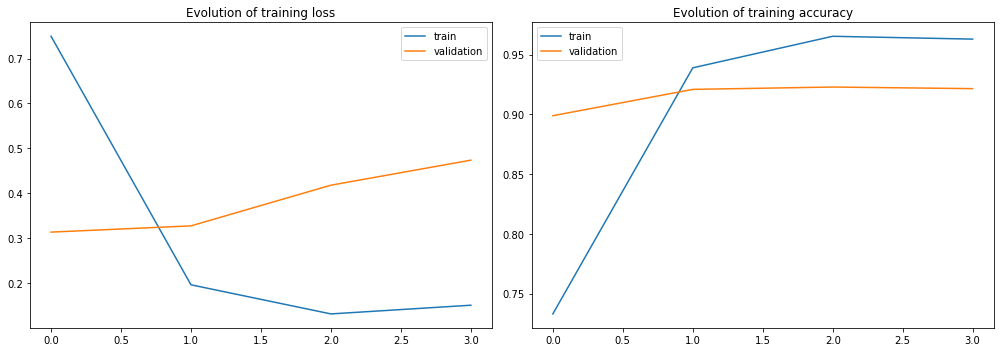

In [69]:
train(model, 'cnn',criterion, optimizer,activate_early_stopping,scheduler, train_loader, val_loader, n_epochs=20, print_every=400, gpu=True)

              precision    recall  f1-score   support

           C       0.82      0.94      0.88      1443
           D       0.92      0.92      0.92      2734
          ED       0.97      0.91      0.94      2187
          EG       0.97      0.94      0.96      1825
           G       0.90      0.90      0.90      1487

    accuracy                           0.92      9676
   macro avg       0.92      0.92      0.92      9676
weighted avg       0.92      0.92      0.92      9676



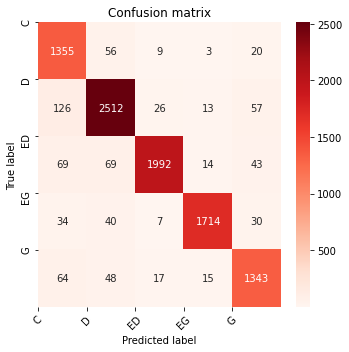

In [70]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'cnn')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

Our CNN model gives slightly better results than the LSTM on the test set but it overfits very quickly.

## 2.3 Classification using CamemBERT

We implement a classifier based on CamemBERT architecture: we use the recurrent part of CamemBERT for encoding and we stack a fully connected layer at the end to perform classification. Since it is a fine tuning procedure, we use a far lower learning rate than for the the two previous arhcitectures.

In [0]:
dftrain,ytrain,dfval,yval,dftest,ytest,label_map = random_split_dataset(df,validation=True,deep=True)

### 2.3.1 Training

In [72]:
#Creating instances of training and validation set
train_set = TweetDatasetBERT(df = dftrain, maxlen = 50, model_name='camembert-base')
val_set = TweetDatasetBERT(df = dfval, maxlen = 50, model_name='camembert-base')
test_set = TweetDatasetBERT(df = dftest, maxlen = 50, model_name='camembert-base')

#Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 32, num_workers = 5,drop_last=True)
val_loader = DataLoader(val_set, batch_size = 32, num_workers = 5,drop_last=True)
test_loader = DataLoader(test_set,batch_size=1,num_workers=5,drop_last=False)

In [73]:
model = CamembertClassifier('camembert-base')
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, verbose=True)
activate_early_stopping = True

Iteration 400 of epoch 1 complete. Loss : 0.889771044254303, Accuracy 0.65625 
Iteration 800 of epoch 1 complete. Loss : 0.6596293449401855, Accuracy 0.8125 
EVALUATION Validation set : mean loss 0.5300834952600745 || mean accuracy 0.865583598613739
Validation loss decreased (inf --> 160.085216).  Saving model ...
Iteration 400 of epoch 2 complete. Loss : 0.4936794936656952, Accuracy 0.875 
Iteration 800 of epoch 2 complete. Loss : 0.4929956793785095, Accuracy 0.875 
EVALUATION Validation set : mean loss 0.3921956868953263 || mean accuracy 0.8892797827720642
Validation loss decreased (160.085216 --> 118.443097).  Saving model ...
Iteration 400 of epoch 3 complete. Loss : 0.3190189003944397, Accuracy 0.875 
Iteration 800 of epoch 3 complete. Loss : 0.29591137170791626, Accuracy 0.9375 
EVALUATION Validation set : mean loss 0.2941470543132318 || mean accuracy 0.9182533025741577
Validation loss decreased (118.443097 --> 88.832410).  Saving model ...
Iteration 400 of epoch 4 complete. Loss

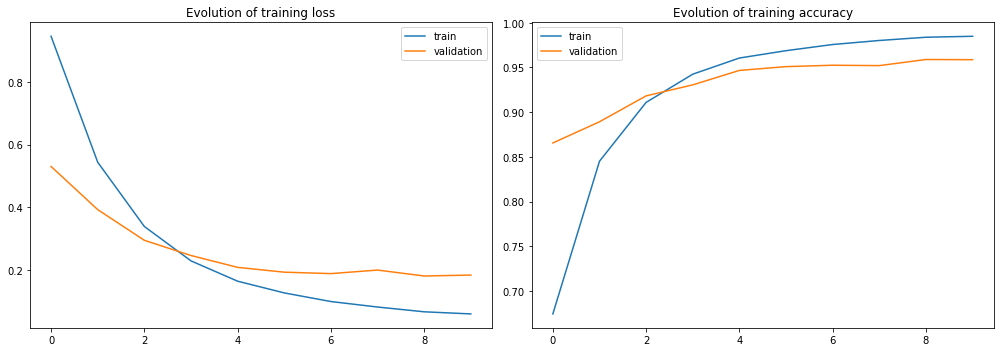

In [75]:
train(model, 'bert',criterion, optimizer,activate_early_stopping, scheduler, train_loader, val_loader, n_epochs=10, print_every=400, gpu=True)

### 2.3.2 Evaluation

For the evaluation part, since we are interested in recall, precision and f1-score, we cannot simply compute an average over batches. 

              precision    recall  f1-score   support

           C       0.95      0.96      0.95      1443
           D       0.96      0.96      0.96      2734
          ED       0.98      0.96      0.97      2187
          EG       0.98      0.97      0.97      1825
           G       0.93      0.97      0.95      1487

    accuracy                           0.96      9676
   macro avg       0.96      0.96      0.96      9676
weighted avg       0.96      0.96      0.96      9676



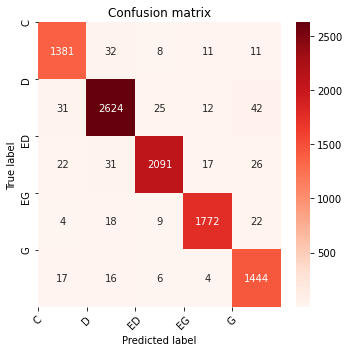

In [76]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'bert')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)


We see that our fine-tuned CamemBERT model performs nearly as well as the beset models in the first part, but we can see that it also overfits (cf training graphs).

### 2.3.3 Interpretation

For this part, we want to visualize which parts of text caught the attention of the classifier. This gives us an insight about how the model works.

In [0]:
from utils.interpretation import get_last_layer_attention,display_attention,visualize_layer_attention

In [0]:
sample = train_set[1]
mean_attn,tokens,attn_data = get_last_layer_attention(model,train_set.tokenizer,sample)

We visualize the attention of the 12 attention heads of the encoder's last layer (which is the one given in input ot the classifier part of our model).

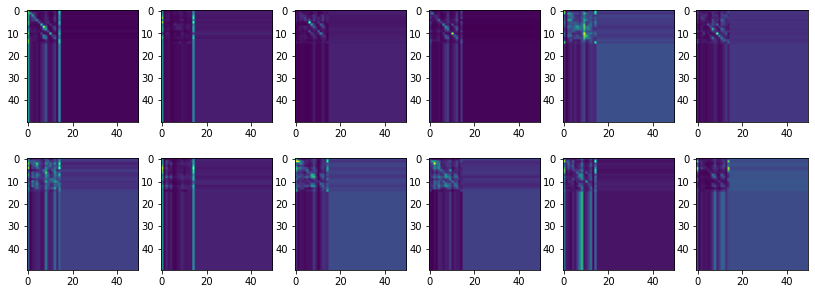

In [79]:
visualize_layer_attention(attn_data['layer11'].cpu().detach().numpy())

Below is a more compact and more explicit visualization of these same attentions. it is obtained by averaging over attentions heads and rows, getting rid of useless tokens (start, end and padding tokens) and summing the attentions over tokens which are parts of the same word. Let's notice however that this procedure does not give us the ties between words of the sentence, but only which words are important and have strong ties with a certain number of other words.

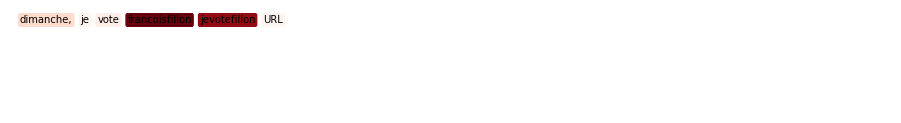

In [80]:
display_attention(tokens,mean_attn,train_set.tokenizer)

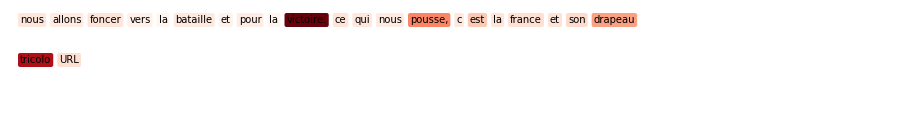

In [85]:
sample = train_set[5]
mean_attn,tokens,attn_data = get_last_layer_attention(model,train_set.tokenizer,sample)
display_attention(tokens,mean_attn,train_set.tokenizer)

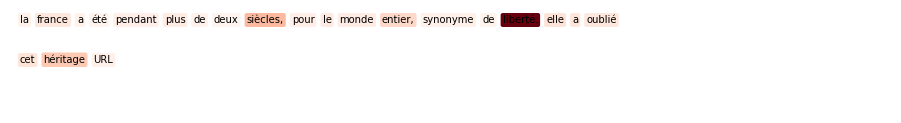

In [89]:
sample = train_set[9]
mean_attn,tokens,attn_data = get_last_layer_attention(model,train_set.tokenizer,sample)
display_attention(tokens,mean_attn,train_set.tokenizer)

In most cases this points to significant words in the sentences, such as "victory", "tricolor", "freedom", or "progress", "solidarity", "deregulation" (not displayed above), which may mean that some political parties use them more than others (which is intuitive). Also, when the name of the candidate is present in the sentence, it attracts the attention of the model, sometimes erroneously.

# 3. Classification with time-wise splitting: robustness evaluation

In this second approach, we split the data time-wise: we train on March and we test on April and May. We expect the performances of our models to drop, especially those which are based on the count vectorizer, which will face many out-of-vocabulary words in the test set. The reason for that is that our tweets are highly contextual: they respond to events happening in a short time window before the tweet. 


This approach is not conventional in terms of training and testing, however if we were to build any kind of software from this, we need to test the robustness of our models to new contexts, which is what motivates us in the first place.

In [0]:
Xtrain,ytrain,Xval,yval,Xtest,ytest,label_map = time_split_dataset(df,validation=True)

## 3.1 Classification without deep learning

Once again, we performed a grid search to select the best hyperparameters, and we only display the results using the optimal hyperparameters.

In [0]:
classifiers = {'Logistic regression':LogisticRegression(),
               'SVM': SVC(),
               'Random Forest': RandomForestClassifier(),
               'Multi Layer Perceptron':MLPClassifier()}
hp = json.load(open('data/hyperparameters_time.json'))

In [131]:
for name,clf in classifiers.items():
    clf.set_params(**hp[name])
    clf.fit(Xtrain,ytrain)
    ypred = clf.predict(Xval)
    boldprint('--------------'+name+'--------------')
    print(evaluate(yval,ypred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


--------------Logistic regression--------------
   accuracy    recall  precision  f1-score
0    0.7805  0.768564   0.800213  0.773275
--------------SVM--------------
   accuracy  recall  precision  f1-score
0  0.230667     0.2   0.046133  0.074973
--------------Random Forest--------------
   accuracy    recall  precision  f1-score
0  0.539667  0.488006   0.818551  0.489758
--------------Multi Layer Perceptron--------------
   accuracy    recall  precision  f1-score
0    0.7985  0.789867    0.80671  0.793712


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [0]:
#use the complete training set
Xtrain_ = vstack((Xtrain, Xval)) 
ytrain_ = np.concatenate((ytrain, yval))

--------------Logistic regression--------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 11.5s
              precision    recall  f1-score   support

           C       0.91      0.53      0.67      2394
           D       0.13      1.00      0.23       210
          ED       0.92      0.67      0.77      2521
          EG       0.69      0.69      0.69       516
           G       0.43      0.79      0.56       360

    accuracy                           0.63      6001
   macro avg       0.62      0.74      0.58      6001
weighted avg       0.84      0.63      0.69      6001



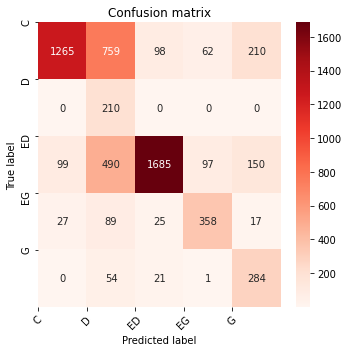

--------------SVM--------------
Training time: 479.5s


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           C       0.00      0.00      0.00      2394
           D       0.03      1.00      0.07       210
          ED       0.00      0.00      0.00      2521
          EG       0.00      0.00      0.00       516
           G       0.00      0.00      0.00       360

    accuracy                           0.03      6001
   macro avg       0.01      0.20      0.01      6001
weighted avg       0.00      0.03      0.00      6001



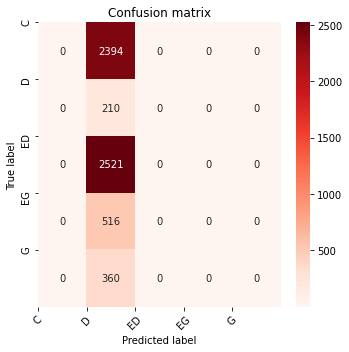

--------------Random Forest--------------
Training time: 14.4s
              precision    recall  f1-score   support

           C       1.00      0.10      0.18      2394
           D       0.05      1.00      0.09       210
          ED       0.90      0.33      0.48      2521
          EG       0.69      0.53      0.60       516
           G       0.74      0.44      0.55       360

    accuracy                           0.28      6001
   macro avg       0.68      0.48      0.38      6001
weighted avg       0.88      0.28      0.36      6001



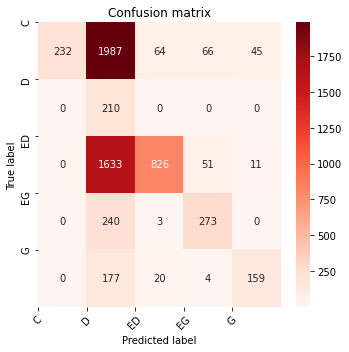

--------------Multi Layer Perceptron--------------


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training time: 375.2s
              precision    recall  f1-score   support

           C       0.85      0.57      0.69      2394
           D       0.13      0.94      0.23       210
          ED       0.92      0.60      0.73      2521
          EG       0.63      0.71      0.67       516
           G       0.47      0.83      0.60       360

    accuracy                           0.63      6001
   macro avg       0.60      0.73      0.58      6001
weighted avg       0.81      0.63      0.68      6001



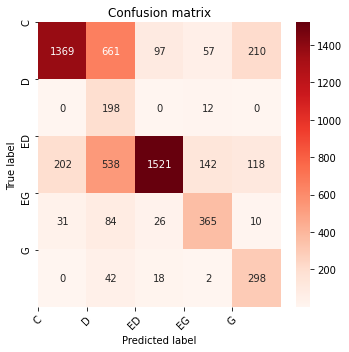

In [133]:
for name,clf in classifiers.items():
    boldprint('--------------'+name+'--------------')
    start = time.time()
    clf.fit(Xtrain_,ytrain_)
    end = time.time()
    print(f'Training time: {end - start:.1f}s')
    ypred = clf.predict(Xtest)
    print(classification_report(ytest,ypred,target_names = sorted_labels))
    plot_confusion_matrix(ytest,ypred,label_map=label_map)

We can observe that the models performances dropped compared to the random split. It probably comes from the preprocessing: the political context evolves with time, so that we must face a lot of out-of-vocabulary words. 

## 3.2 Classification using custom neural networks

In [0]:
dftrain,ytrain,dfval,yval,dftest,ytest,label_map = time_split_dataset(df,validation=True,deep=True)

In [0]:
train_set,tokenizer = build_tweet_dataset(dftrain)
val_set, _ = build_tweet_dataset(dfval,tokenizer)
test_set, _ = build_tweet_dataset(dftest,tokenizer)

train_loader = DataLoader(train_set,batch_size = 32,num_workers = 5,drop_last=True)
val_loader = DataLoader(val_set,batch_size = 32,num_workers = 5,drop_last=True)
test_loader = DataLoader(test_set,batch_size = 1,num_workers = 5,drop_last=False)

### 3.2.1 Custom LSTM

In [96]:
vocab_size = tokenizer.num_words + 1
output_size = 5
embedding_dim = 100
hidden_dim = 100
n_layers = 1
model = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = None
activate_early_stopping = True

Iteration 400 of epoch 1 complete. Loss : 1.2366639375686646, Accuracy 0.625 
Iteration 800 of epoch 1 complete. Loss : 1.1517415046691895, Accuracy 0.75 
EVALUATION Validation set : mean loss 1.2673448910687697 || mean accuracy 0.6276738047599792
Validation loss decreased (inf --> 236.993495).  Saving model ...
Iteration 400 of epoch 2 complete. Loss : 0.9917398691177368, Accuracy 0.9375 
Iteration 800 of epoch 2 complete. Loss : 1.0912487506866455, Accuracy 0.84375 
EVALUATION Validation set : mean loss 1.2524064999213194 || mean accuracy 0.6430481672286987
Validation loss decreased (236.993495 --> 234.200015).  Saving model ...
Iteration 400 of epoch 3 complete. Loss : 1.0010579824447632, Accuracy 0.9375 
Iteration 800 of epoch 3 complete. Loss : 1.0649335384368896, Accuracy 0.84375 
EVALUATION Validation set : mean loss 1.2386630046813882 || mean accuracy 0.6609291434288025
Validation loss decreased (234.200015 --> 231.629982).  Saving model ...
Iteration 400 of epoch 4 complete. L

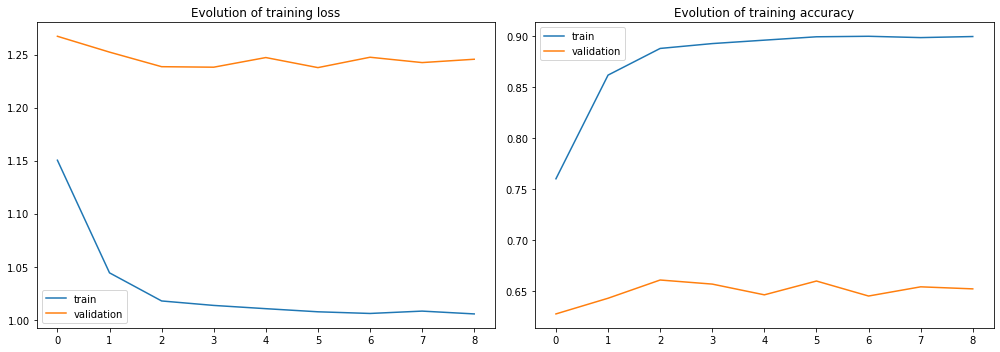

In [98]:
train(model, 'rnn',criterion, optimizer,activate_early_stopping,scheduler, train_loader, val_loader, n_epochs=10, print_every=400, gpu=True)

              precision    recall  f1-score   support

           C       0.55      0.18      0.27      2394
           D       0.07      0.75      0.12       210
          ED       0.77      0.35      0.48      2521
          EG       0.35      0.39      0.37       516
           G       0.17      0.51      0.26       360

    accuracy                           0.31      6001
   macro avg       0.38      0.44      0.30      6001
weighted avg       0.59      0.31      0.36      6001



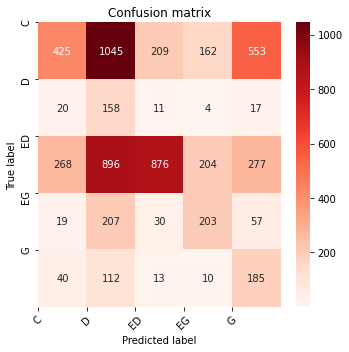

In [99]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'rnn')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

The LSTM is largely outperformed by the benchmark models. However, we can notice that our best architecure is a bit smaller than in the first part, which indicates that a smaller architecture is better at generalizing.

A word on the unusual plots: We did not expect the graphs of validation and train to be close, since the data distribution is not the same in the two sets. It is normal for the loss (resp. the accuracy) to be lower (resp. higher) on the training set, even before overfitting. 

### 3.2.2 Custom CNN

In [0]:
max_features = 8000
embed_dim = 100
num_filters = [30,30]
filter_sizes = [3,2]
model = CNN(max_features,embed_dim,num_filters,filter_sizes)
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2, verbose=True)
activate_early_stopping = True

Iteration 400 of epoch 1 complete. Loss : 0.18559539318084717, Accuracy 0.96875 
Iteration 800 of epoch 1 complete. Loss : 0.1535966545343399, Accuracy 1.0 
EVALUATION Validation set : mean loss 0.8628874864170258 || mean accuracy 0.7030414342880249
Validation loss decreased (inf --> 161.359960).  Saving model ...
Iteration 400 of epoch 2 complete. Loss : 0.04176364839076996, Accuracy 1.0 
Iteration 800 of epoch 2 complete. Loss : 0.08038070052862167, Accuracy 0.96875 
EVALUATION Validation set : mean loss 1.059845624680825 || mean accuracy 0.7209224700927734
EarlyStopping counter: 1 out of 3
Iteration 400 of epoch 3 complete. Loss : 0.10776162892580032, Accuracy 0.96875 
Iteration 800 of epoch 3 complete. Loss : 0.05877920985221863, Accuracy 1.0 
EVALUATION Validation set : mean loss 1.5771109449034706 || mean accuracy 0.7267714142799377
EarlyStopping counter: 2 out of 3
Iteration 400 of epoch 4 complete. Loss : 0.2406916618347168, Accuracy 0.9375 
Iteration 800 of epoch 4 complete. L

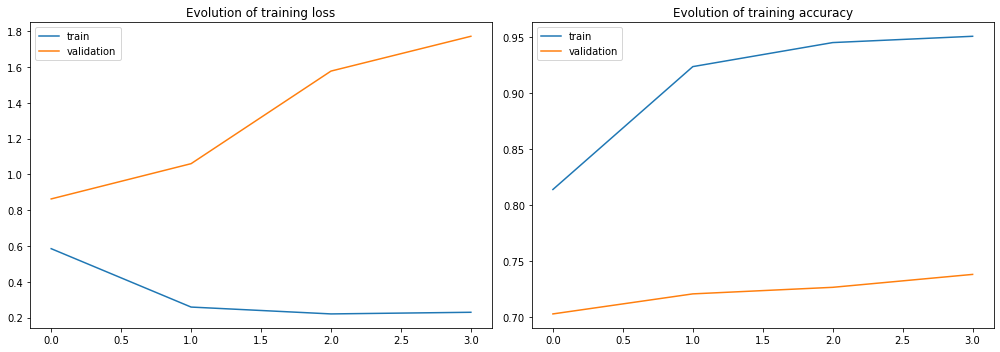

In [102]:
train(model, 'cnn',criterion, optimizer,activate_early_stopping,scheduler, train_loader, val_loader, n_epochs=10, print_every=400, gpu=True)

              precision    recall  f1-score   support

           C       0.58      0.35      0.44      2394
           D       0.08      0.73      0.15       210
          ED       0.71      0.46      0.56      2521
          EG       0.48      0.37      0.42       516
           G       0.30      0.52      0.38       360

    accuracy                           0.42      6001
   macro avg       0.43      0.49      0.39      6001
weighted avg       0.59      0.42      0.47      6001



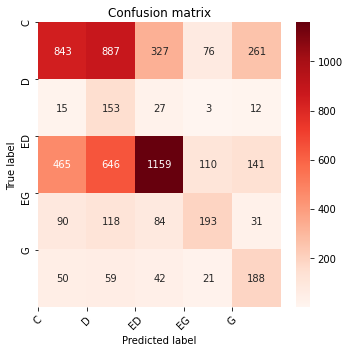

In [103]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'cnn')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

This model outperforms the LSTM, and trains in a very little number of epochs. It also quickly overfits. It is still largely outperformed by the logistic regression.

For both the LSTM and the CNN, the performance dramatically dropped, and the architectures shrank.

## 3.3 Using CamemBERT

### 3.3.1 Training

In [0]:
#Creating instances of training and validation set
train_set = TweetDatasetBERT(df = dftrain, maxlen = 50, model_name='camembert-base')
val_set = TweetDatasetBERT(df = dfval, maxlen = 50, model_name='camembert-base')
test_set = TweetDatasetBERT(df = dftest, maxlen = 50, model_name='camembert-base')

#Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 32, num_workers = 5,drop_last=True)
val_loader = DataLoader(val_set, batch_size = 32, num_workers = 5,drop_last=True)
test_loader = DataLoader(test_set,batch_size=1,num_workers=5,drop_last=False)

In [0]:
model = CamembertClassifier('camembert-base')
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=.5,patience=2)
activate_early_stopping = False

Iteration 400 of epoch 1 complete. Loss : 0.27636200189590454, Accuracy 0.9375 
Iteration 800 of epoch 1 complete. Loss : 0.06072590500116348, Accuracy 1.0 
EVALUATION Validation set : mean loss 0.6409756971553048 || mean accuracy 0.7832553386688232
Iteration 400 of epoch 2 complete. Loss : 0.2965587377548218, Accuracy 0.9375 
Iteration 800 of epoch 2 complete. Loss : 0.03140980005264282, Accuracy 1.0 
EVALUATION Validation set : mean loss 0.6989714215225714 || mean accuracy 0.8026403784751892
Iteration 400 of epoch 3 complete. Loss : 0.013351626694202423, Accuracy 1.0 
Iteration 800 of epoch 3 complete. Loss : 0.03207659721374512, Accuracy 1.0 
EVALUATION Validation set : mean loss 0.6854274058166672 || mean accuracy 0.8203542828559875
Iteration 400 of epoch 4 complete. Loss : 0.013644196093082428, Accuracy 1.0 
Iteration 800 of epoch 4 complete. Loss : 0.03278094902634621, Accuracy 0.96875 
EVALUATION Validation set : mean loss 0.8406608109486932 || mean accuracy 0.803810179233551
It

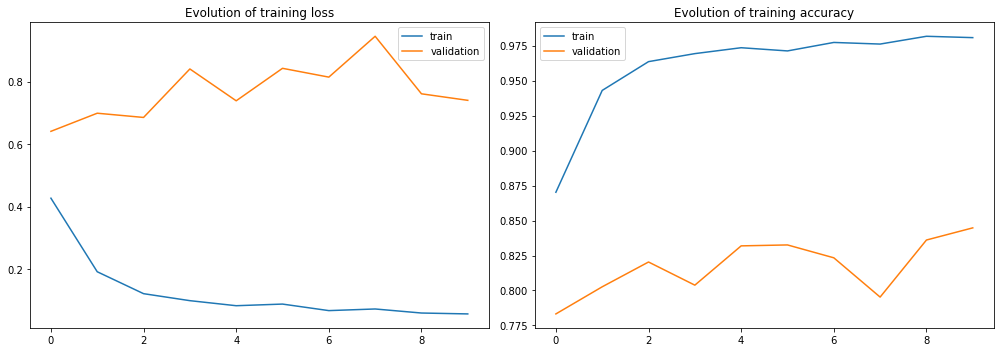

In [108]:
train(model, 'bert',criterion, optimizer,activate_early_stopping,scheduler, train_loader, val_loader, n_epochs=10, print_every=400, gpu=True)

### 3.3.2 Evaluation

              precision    recall  f1-score   support

           C       0.76      0.68      0.72      2394
           D       0.23      0.78      0.35       210
          ED       0.87      0.64      0.73      2521
          EG       0.68      0.74      0.71       516
           G       0.39      0.80      0.52       360

    accuracy                           0.68      6001
   macro avg       0.59      0.73      0.61      6001
weighted avg       0.76      0.68      0.70      6001



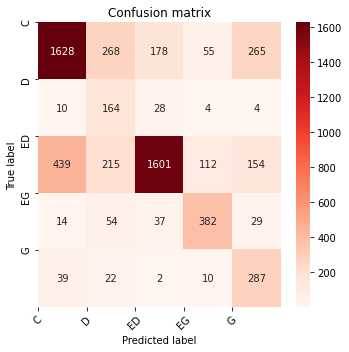

In [109]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'bert')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

This model is the best of our models, and therefore the most robust. Despite CamemBERT being context insensitive (since it does not face out-of-vocabulary words), it still performs poorly compared to the first part. This is, in our opinion, still linked to the context: the model does not know how to map words from a new context to political lines. This suggests that there are very few "patterns" (ie words or phrases used specifically by one or two political parties) in the politician discourse which would be used in a majority of contexts, and upon which we could build a classifier. 


### 3.3.3 Interpretation

In [0]:
sample = train_set[1]
mean_attn,tokens,attn_data = get_last_layer_attention(model,train_set.tokenizer,sample)

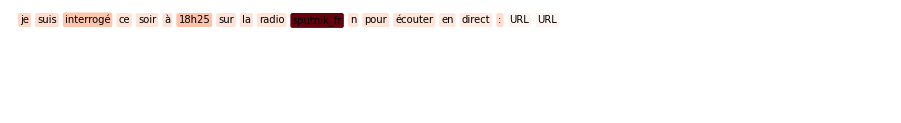

In [136]:
display_attention(tokens,mean_attn,train_set.tokenizer)

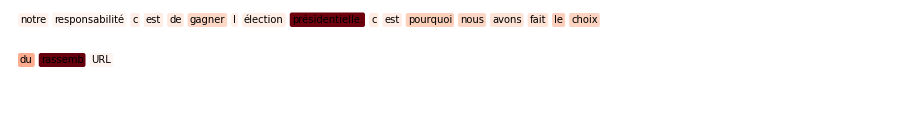

In [139]:
sample = train_set[3]
mean_attn,tokens,attn_data = get_last_layer_attention(model,train_set.tokenizer,sample)
display_attention(tokens,mean_attn,train_set.tokenizer)

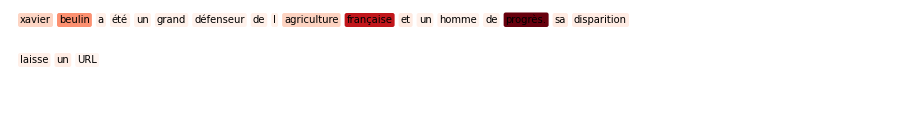

In [141]:
sample = train_set[5]
mean_attn,tokens,attn_data = get_last_layer_attention(model,train_set.tokenizer,sample)
display_attention(tokens,mean_attn,train_set.tokenizer)

Once again, the model's attention seems drawn to relevant part of the sentences.